# Data Cleaning / Linear Regression

We will explore the **FIFA 19** dataset, which contains detailed attributes for every player registered in the latest edition of FIFA 19 database.    
It was scrapped from this [website](https://sofifa.com/), and we can find the source code [here](https://github.com/amanthedorkknight/fifa18-all-player-statistics/tree/master/2019).

Our goal is to find out how the `Overall` score by player is calculated

There are 2 main parts:

* Data Import & Cleaning, the output of this part is provided in the csv file `Assignment_2_data_cleaned`
* Simple Modeling with the cleaned data

# Data Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We Load the csv file `data.csv` into a dataframe called `df`

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount = False)
os.chdir("/content/drive/My Drive/PW_2")
df = pd.read_csv('Fifa_data.csv', index_col=0)

In [ ]:
df.head()

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,...,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,...,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,...,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",NaN,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",NaN,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,...,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


Let's print how many columns that are in df columns types

In [ ]:

print(len(list(df.columns.values)))

88


`to_drop` is a list containing columns that are not useful for modeling, we will remove them and print the new shape of `df`

In [ ]:
to_drop =['ID', 'Name', 'Photo','Nationality', 'Flag','Club','Club Logo', 'Real Face', 'Joined', 'Loaned From', 'Contract Valid Until']
df.drop(columns=to_drop, axis=1, inplace=True)

In [ ]:
df.head()

,Age,Overall,Potential,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Position,Jersey Number,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,31,94,94,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,RF,10.0,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,61+2,64+2,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,33,94,94,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,ST,7.0,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,26,92,93,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,LW,10.0,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,27,91,93,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,GK,1.0,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,27,91,92,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,RCM,7.0,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


# Data Cleaning

## Handling missing values

We will build a dataframe called `missing` which has the following format:

* `pct` is the percentage of missing values, **takes values between `0` and `100`**
* the index is the column names

|     | pct |
|-----|-----|
|......|.....|
|Strength |0.263635|
|.....|.....|



In [ ]:
missing = pd.DataFrame(df.isnull().sum()/len(df)*100, columns= ['pct'])
missing.head()

,pct
Age,0.0
Overall,0.0
Potential,0.0
Value,0.0
Wage,0.0


We now emove from `missing`, rows with `pct`= 0   
We sort `missing` in ascending order of `pct` and print its head

In [ ]:
missing =missing[missing['pct'] != 0]
missing.sort_values('pct', inplace=True)
missing.head()

,pct
Preferred Foot,0.263635
Strength,0.263635
Stamina,0.263635
Jumping,0.263635
ShotPower,0.263635


Now, let's fill missing values where the % of missing is lower than 1 (1%).   
First, we identify these columns in a list named `cols_to_fill`

In [ ]:
cols_to_fill = list(missing[missing['pct'] < 1].index)
print(cols_to_fill)
print(len(cols_to_fill), type(cols_to_fill))

['Preferred Foot', 'Strength', 'Stamina', 'Jumping', 'ShotPower', 'Balance', 'Reactions', 'Agility', 'SprintSpeed', 'LongShots', 'Acceleration', 'LongPassing', 'GKReflexes', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'BallControl', 'Aggression', 'Interceptions', 'Positioning', 'International Reputation', 'Weak Foot', 'Skill Moves', 'Work Rate', 'Body Type', 'Height', 'Weight', 'Curve', 'GKPositioning', 'GKHandling', 'GKDiving', 'SlidingTackle', 'StandingTackle', 'Marking', 'Composure', 'Penalties', 'Vision', 'GKKicking', 'FKAccuracy', 'Jersey Number', 'Position']
44 <class 'list'>


We define a function (`fill_nas_by_type`) to fill null values by column type:

* if a column type is `Object`, fill it with the **most frequent value**
* otherwise, fill it with the **median value**

In [ ]:
def fill_nas_by_type(df, col_name):
    """Fill null values in df according to col_name type
    
    Parameters
    ----------
    df : dataframe, (default=None)
        input dataframe
    col_name : str, (default=None)
        column with null values to fill
        
    Returns
    ------- 
    df with filled values in col_name
    """
    
    if df[col_name].isnull().sum() == 0:
      return df
    if df[col_name].dtype == 'O':
      fill_value = df[col_name].value_counts().index[0]
      df[col_name].fillna(fill_value, inplace = True)
    else:
      fill_value = df[col_name].median()
      df[col_name].fillna(fill_value, inplace=True)
    return df

Loop through `cols_to_fill` and apply the defined function `fill_nas_by_type` to fill null values

In [ ]:
for i in cols_to_fill:
  df = fill_nas_by_type(df.copy(),i)

For the remaining missing values, let's just remove them.    

In [ ]:
df.dropna(axis = 0, inplace=True)

## Correct some columns format

### Monetary columns

In [ ]:
money_cols = ['Value','Wage', 'Release Clause']
df[money_cols].head()

,Value,Wage,Release Clause
0,110500000.0,565000.0,226500000.0
1,77000000.0,405000.0,127100000.0
2,118500000.0,290000.0,228100000.0
3,102000000.0,355000.0,196400000.0
4,93000000.0,340000.0,172100000.0


We build a function which extracts the monetary value from a string. It should return a number with no decimals.   

In [ ]:
def get_value(value_text):
    """Extract the monetary value from a string
    
    Parameters
    ----------
    value_text: str, (default=None)
        a string containing a number ending with M, K or nothing
        
    Returns
    -------
    a float with no decimals
    
    Examples
    --------
    >>> get_value('€7.1K')
    7100.0
    """
    print(value_text[0])
    multiplier = value_text[-1]
    print(multiplier)

    if multiplier == 'M':
        number = float(value_text[1:-1])
        return number * 1000000
    elif multiplier == 'K':
        number = float(value_text[1:-1])
        return number * 1000
    else:
        return float(value_text[1:])    

We loop through `money_cols` and apply the defined function `get_value` to convert them to numeric

In [ ]:
for f in money_cols:
    df[f] = df[f].apply(get_value)

### Height and Weight columns

We start by printing the unique values for `Height`

In [ ]:
df['Height'].unique()

array([174., 189., 180., 156., 177., 183., 171., 155., 186., 165., 192.,
       195., 168., 201., 198., 162., 158., 204., 207.])

Then, we write a function (`get_height`) which converts the Height from a string in feet to  a number in `cm` with no decimals.    
1 feet = 30.48 cm. For example `get_height("5'10")` = `155`

In [ ]:
def get_height(x):
    return  round(float(x.replace("'", ".")) * 30.48, 0) 

We apply the previous defined function on `Height`

In [ ]:
df['Height'] = df['Height'].apply(get_height)

The same thing with `Weight`

In [ ]:
df['Weight'].unique()

array([ 72.,  83.,  68.,  70.,  74.,  66.,  86.,  82.,  80.,  76.,  78.,
        67.,  75.,  89.,  73.,  77.,  85.,  71.,  84.,  59.,  79.,  92.,
        94.,  61.,  64.,  69.,  81.,  60.,  90.,  91.,  95.,  97.,  65.,
        87.,  62.,  88.,  63., 100.,  93.,  98.,  57.,  56.,  58., 101.,
        96.,  55.,  52.,  99.,  53., 110.,  50.,  54., 106.])

We write a function (`get_weight`) which converts the **Weight** from a string in `lbs` to a number in `kg` with no decimals.    
1 lbs = 0.453592 kg. For example `get_weight("115lbs")` = `52`

In [ ]:
def get_weight(x):
    return  round(float(x.split('lbs')[0]) * 0.453592, 0)

We Apply the previous defined function on `Weight`

In [ ]:
df['Weight'] = df['Weight'].apply(get_weight)

## Convert text columns to numeric

Let's identify non-numeric text columns in a list called `text_cols`

In [ ]:
text_cols = [i for i in df.columns if df[i].dtype == 'object']

Then let's build a list named `cols_to_remove` containing columns from `text_cols`, if a column has a number of unique values greater than **10** (`> 10`)

In [ ]:
cols_to_remove = []
for f in text_cols:
  if df[f].nunique() > 10:
    cols_to_remove.append(f)

remove `cols_to_remove` columns from `df` and print its shape

In [ ]:
df.drop(cols_to_remove, axis =1,inplace=True)

# Model building

Let's load the csv that is already cleaned, as a "checkpoint".

In [ ]:
df = pd.read_csv('Fifa_cleaned.csv')
df.head()

,Age,Overall,Potential,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Jersey Number,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,31,94,94,110500000.0,565000.0,2202,0,5.0,4.0,4.0,8,3,10.0,174.0,72.0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226500000.0
1,33,94,94,77000000.0,405000.0,2228,1,5.0,4.0,5.0,1,1,7.0,189.0,83.0,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127100000.0
2,26,92,93,118500000.0,290000.0,2143,1,5.0,5.0,5.0,2,4,10.0,180.0,68.0,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228100000.0
3,27,91,92,102000000.0,355000.0,2281,1,4.0,5.0,4.0,0,5,7.0,156.0,70.0,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196400000.0
4,27,91,91,93000000.0,340000.0,2142,1,4.0,4.0,4.0,2,5,10.0,177.0,74.0,81.0,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0,11.0,12.0,6.0,8.0,8.0,172100000.0


We load the target variable `Overall` into a dataframe and name it `y`. Then,let's load the features into a second dataframe and name it `X`. We plot a histogram of `y`, and choose the number of bins as 100.

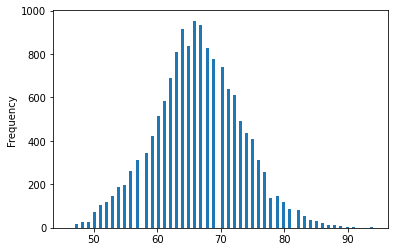

In [ ]:
y = df['Overall']
x = df.drop(columns=['Overall'])
y.plot.hist(bins=100 )


We split the data set into a training set and a test set and choose `test_size` = 0.3 and `random_state` = 123  

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)


print(reg.predict(X_test))
print(y_test)

[60.67478546 60.88778585 70.26882896 ... 60.28463081 67.29377745
 64.71340439]
11672    61
11029    62
2015     74
9257     64
13901    55
         ..
5520     68
8222     65
12224    60
4986     69
9235     64
Name: Overall, Length: 4423, dtype: int64


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math
y_pred = reg.predict(X_test)
score = reg.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print(mse, score)

3.0074136038004893 0.9357188804626775
